# Лабораторная работа 3
## Реализация алгоритмов машинного обучения

Выполнил Моисеенков Илья, М8О-408Б-19

### Задание:
1. Реализовать выбранный в ЛР1 алгоритм
2. Сранить результаты с алгоритмом из sklearn
3. Выбить больший скор по сравнению со значением скора, которое было получено на первой лабораторной работе
4. Выбрать "обратный" алгоритм (вместо классификации - регрессию и наоборот)
5. Выбрать любой табличный набор данных для "обратного" алгоритма. Набор данных должен быть у каждого свой, то есть датасеты не должны пересекаться.
6. Реализовать "обратный" алгоритм

In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import tqdm
import math

In [135]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.base import TransformerMixin

Подготовка датасета (из прошлой лабы)

In [136]:
df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

In [137]:
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [138]:
numerical_features = ['MentHlth', 'PhysHlth', 'BMI']
target = 'HeartDiseaseorAttack'
categorical_features = [feat for feat in list(df.columns) if feat != target and feat not in numerical_features]

Пайплайн предобработки данных

In [139]:
data_preprocessing = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), categorical_features),
    ('stdscale', StandardScaler(), ['BMI']),
    ('minmax', MinMaxScaler(), [feat for feat in numerical_features if feat != 'BMI'])
])

In [140]:
class ToArrayTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

Делим на трейн и тест

In [141]:
from sklearn.model_selection import train_test_split

In [142]:
X = df.drop(target, axis=1)
y = df[target]
assert len(X) == len(y)

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0xDEAD)

In [144]:
X_train.shape, X_test.shape

((202944, 21), (50736, 21))

Функция для подсчета метрик классификации

In [145]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve

In [146]:
def get_metrics(model, X_test, y_true):
    y_pred = model.predict(X_test)
    y_pred_probas = model.predict_proba(X_test)
    if len(y_pred_probas.shape) == 2:
            y_pred_probas = y_pred_probas[:, 1]
    
    print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('Precision = ', precision_score(y_test, y_pred))
    print('Recall = ', recall_score(y_test, y_pred))
    print('ROC AUC = ', roc_auc_score(y_test, y_pred_probas))
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probas)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    plt.xlabel('Recall')
    plt.ylabel('Presicion')
    plt.title('Precision-recall curve')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid()
    plt.plot(recall, precision)
    
    plt.subplot(2, 1, 2)
    plt.xlabel('False Positive rate')
    plt.ylabel('True Positive rate')
    plt.title('ROC curve')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid()
    plt.plot(fpr, tpr)

    plt.show()

#### Задание 1
В первой ЛР я выбрал случайный лес. Реализуем его руками.

Сначала нам понадобится класс для одного дерева.

In [147]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV

In [97]:
class Node:
    def __init__(self, probability):
        self.probability = probability # вероятность единички при попадании в эту вершину
        self.feature_index = 0  # по какой фиче разбиваем
        self.threshold = 0  # по какому порогу фичи разбиваем
        self.left = None  # левое поддерево
        self.right = None  # правое поддерево

In [109]:
class MyDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=15):
        self.max_depth = max_depth
    
    def fit(self, X, y, random_features=False):
        X, y = check_X_y(X, y)
        self.n_classes = len(set(y))
        self.n_features = X.shape[1]
        self.weights = np.array([np.sum(y == i) for i in range(1, -1, -1)]) / len(y) # веса считаем по распределению таргетов
        # self.weights = np.array([10, 1])
        self.tree = self._build_tree(X, y, random_features)
    
    def _build_tree(self, X, y, depth=0, random_features=False):
        num_samples_per_class = [np.sum(y == i) for i in range(2)]
        proba = num_samples_per_class[1] / sum(num_samples_per_class)
        node = Node(probability=proba)
        if depth < self.max_depth:
            feature_id, threshold = self._get_best_split(X, y, random_features) # ищем лучший сплит
            if feature_id is not None:
                # None может быть только если мы в листе
                indices_left = X[:, feature_id] < threshold
                indices_right = X[:, feature_id] >= threshold
                X_left, y_left = X[indices_left], y[indices_left] # в одну сторону идет все что меньше порога
                X_right, y_right = X[indices_right], y[indices_right] # в другую сторону все остальное
                node.feature_index = feature_id
                node.threshold = threshold
                node.left = self._build_tree(X_left, y_left, depth + 1) # рекурсивно строим дерево дальше
                node.right = self._build_tree(X_right, y_right, depth + 1)
        return node
    
    def _get_best_split(self, X, y, random_features=False):
        m = y.size
        if m <= 1:
            # в вершине остались только элементы одного класса -> это лист
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.n_classes)]
        best_gini = 1.0 - sum((self.weights[i] * num_parent[i] / m) ** 2 for i in range(self.n_classes))
        best_feature_id, best_threshold = None, None
        
        features = list(range(self.n_features))
        if random_features is True:
            features = np.array(random.shuffle(features))
            feat_num = int(np.ceil(np.sqrt(self.n_features)))
            features = np.resize(features, feat_num)

        for feature_id in features:
            # смотрим каждую фичу
            thresholds, classes = zip(*sorted(zip(X[:, feature_id], y)))
            num_left = [0] * self.n_classes
            num_right = num_parent.copy()
            for i in range(1, m):
                if thresholds[i] == thresholds[i - 1]:
                    continue
                
                # смотрим все возможные разбиения и ищем лучшее по критерию Джини
                c = int(classes[i - 1])
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum((self.weights[x] * num_left[x] / i) ** 2 for x in range(self.n_classes))
                gini_right = 1.0 - sum((self.weights[x] * num_right[x] / (m - i)) ** 2 for x in range(self.n_classes))
                gini = (i * gini_left + (m - i) * gini_right) / m
                
                if gini < best_gini:
                    best_gini = gini
                    best_feature_id = feature_id
                    best_threshold = (thresholds[i] + thresholds[i-1]) / 2
        return best_feature_id, best_threshold
    
    def predict(self, X, threshold=0.5):
        return np.array(self.predict_proba(X)) > threshold
    
    def predict_proba(self, X):
        X = check_array(X)
        res = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            node = self.tree
            while node.left:
                if X[i][node.feature_index] < node.threshold:
                    node = node.left
                else:
                    node = node.right
            res[i] = node.probability
        return res

Теперь опишем класс для случайного леса

In [110]:
class MyRandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.trees = []
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        for i in tqdm.tqdm(range(self.n_estimators)):
            tree = MyDecisionTree()
            X_sample, y_sample = self._data_bagging(X, y)
            tree.fit(X_sample, y_sample, random_features=True)
            self.trees.append(tree)
    
    def _data_bagging(self, X,y):
        x_size = len(X)
        x_sample = []
        y_sample = []
        while len(x_sample) < x_size:
            ind = random.randrange(x_size)
            x_sample.append(X[ind])
            y_sample.append(y[ind])
        x_sample = np.array(x_sample)
        y_sample = np.array(y_sample)
        return x_sample, y_sample
    
    def predict(self, X, threshold=0.5):
        return np.array(self.predict_proba(X)) > threshold
    
    def predict_proba(self, X):
        X = check_array(X)
        res = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            for tree in self.trees:
                node = tree.tree
                while node.left:
                    if X[i][node.feature_index] < node.threshold:
                        node = node.left
                    else:
                        node = node.right
                res[i] += node.probability
        return res / len(self.trees)

Проверим работоспособность этой штуки

In [111]:
rf_my = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('random_forest', MyRandomForest(n_estimators=100))
    ]
)

In [112]:
rf_my.fit(X_train, y_train);

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [6:45:30<00:00, 243.30s/it]


Accuracy =  0.9043479974771366
Precision =  0.0
Recall =  0.0
ROC AUC =  0.5007178576240461


C:\Users\moise\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


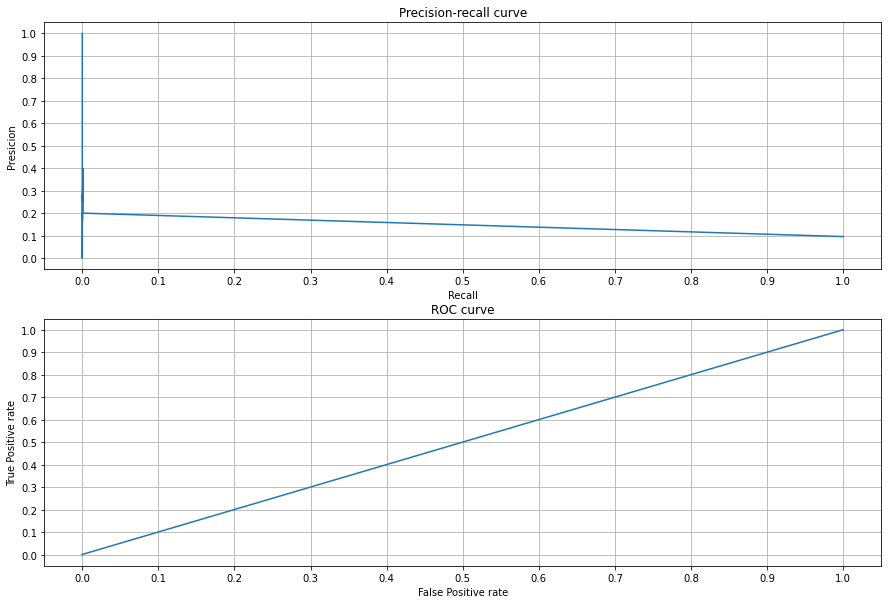

In [113]:
get_metrics(rf_my, X_test, y_test)

Из-за сильного дисбаланса классов (91/9) мой случайный лес понял, что нужно всегда предсказывать только нули, хотя я пробовал добавить веса к классу и испольовать ограничения по количеству элементов в листах. Вероятно, алгоритм в sklearn реализован с большим количеством оптимизаций, благодаря чему он работает быстрее и точнее.

Я проверил работу своего случайного леса на сбалансированных данных и получил результат, сравнимый с результатом библиотечного алгоритма.

#### Задание 2
Еще раз обучим лес из склерна, чтобы сравнить результаты

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('random_forest', RandomForestClassifier(class_weight='balanced', n_estimators=100))
    ]
)

In [47]:
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['HighBP', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'Stroke', 'Diabetes',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'AnyHealthcare',
                                                   'NoDocbcCost', 'GenHlth',
                                                   'DiffWalk', 'Sex', 'Age',
                                                   'Education', 'Income']),
                                                 ('stdscale', StandardScaler(),
                 

Accuracy =  0.8977846105329549
Precision =  0.37748344370860926
Recall =  0.10570780960230786
ROC AUC =  0.8108301506480443


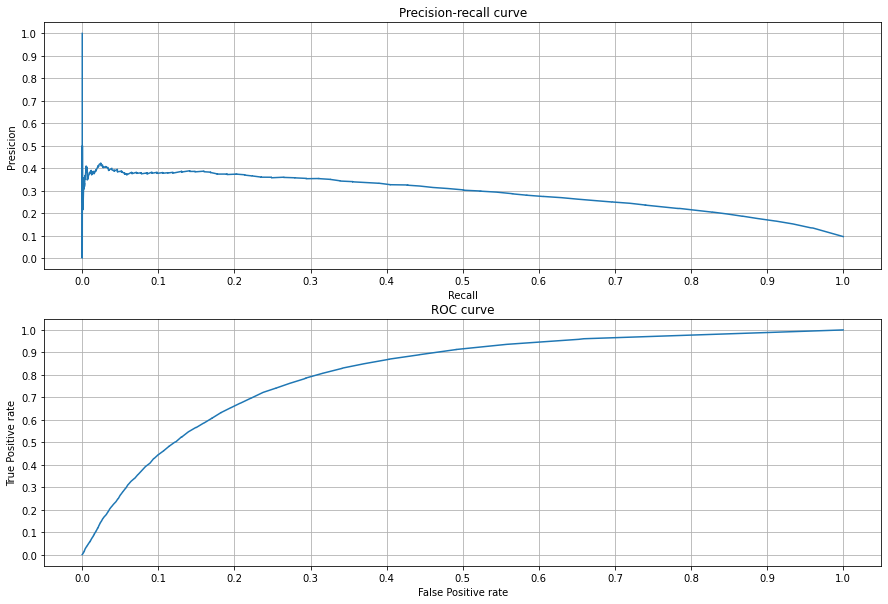

In [48]:
get_metrics(rf, X_test, y_test)

#### Задание 3

Попробуем увеличить скор из прошлой лабы (т.е. из задания 2 этой лабы). Для этого погридсерчим по различным параметрам классификатора

In [49]:
rf_new = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('random_forest', RandomForestClassifier(class_weight='balanced'))
    ]
)

In [51]:
from sklearn.model_selection import GridSearchCV

rf_new_gs = GridSearchCV(rf_new, {
    'random_forest__n_estimators': [50, 100, 200],
    'random_forest__criterion': ['gini', 'entropy'],
    'random_forest__min_samples_split': [2, 4, 6],
    'random_forest__min_samples_leaf': [1, 2, 4],
})
rf_new_gs.fit(X_train, y_train)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\moise\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\moise\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['HighBP',
                                                                          'HighChol',
                                                                          'CholCheck',
                                                                          'Smoker',
                                                                          'Stroke',
                                                                          'Diabetes',
                                                                          'PhysActivity',
                                                                          'Fruits',
                                                                        

In [53]:
rf_new_gs.best_params_

{'random_forest__criterion': 'entropy',
 'random_forest__min_samples_leaf': 1,
 'random_forest__min_samples_split': 2,
 'random_forest__n_estimators': 200}

Accuracy =  0.8981393882056133
Precision =  0.38677210639827464
Recall =  0.11085926231197198
ROC AUC =  0.8145672470522201


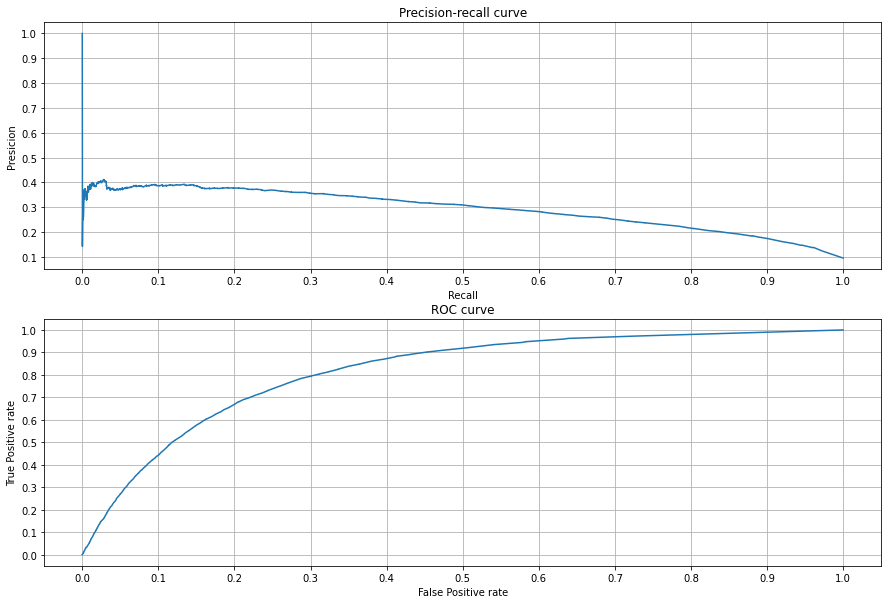

In [54]:
get_metrics(rf_new_gs, X_test, y_test)

Мы смогли получить чуть более хороший результат за счет тюнинга модели

#### Задания 4, 5

Для решения задачи регрессии выберу алгоритм линейной регрессии.

Задача: по характеристикам телефона нужно предсказать его стоимость.

Посмотрим на имеющийся датасет

In [212]:
df_phones = pd.read_csv('Cellphone.csv')

In [213]:
df_phones.head()

,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
0,203,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
3,99,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
4,880,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


In [214]:
df_phones.shape

(161, 14)

In [215]:
df_phones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product_id    161 non-null    int64  
 1   Price         161 non-null    int64  
 2   Sale          161 non-null    int64  
 3   weight        161 non-null    float64
 4   resoloution   161 non-null    float64
 5   ppi           161 non-null    int64  
 6   cpu core      161 non-null    int64  
 7   cpu freq      161 non-null    float64
 8   internal mem  161 non-null    float64
 9   ram           161 non-null    float64
 10  RearCam       161 non-null    float64
 11  Front_Cam     161 non-null    float64
 12  battery       161 non-null    int64  
 13  thickness     161 non-null    float64
dtypes: float64(8), int64(6)
memory usage: 17.7 KB


In [216]:
df_phones.describe()

,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,675.559006,2215.596273,621.465839,170.426087,5.209938,335.055901,4.857143,1.502832,24.501714,2.204994,10.378261,4.503106,2842.111801,8.921739
std,410.851583,768.187171,1546.618517,92.888612,1.509953,134.826659,2.444016,0.599783,28.804773,1.609831,6.181585,4.342053,1366.990838,2.192564
min,10.000000,614.000000,10.000000,66.000000,1.400000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,800.000000,5.100000
25%,237.000000,1734.000000,37.000000,134.100000,4.800000,233.000000,4.000000,1.200000,8.000000,1.000000,5.000000,0.000000,2040.000000,7.600000
50%,774.000000,2258.000000,106.000000,153.000000,5.150000,294.000000,4.000000,1.400000,16.000000,2.000000,12.000000,5.000000,2800.000000,8.400000
75%,1026.000000,2744.000000,382.000000,170.000000,5.500000,428.000000,8.000000,1.875000,32.000000,3.000000,16.000000,8.000000,3240.000000,9.800000
max,1339.000000,4361.000000,9807.000000,753.000000,12.200000,806.000000,8.000000,2.700000,128.000000,6.000000,23.000000,20.000000,9500.000000,18.500000


In [217]:
df_phones.isna().sum()

Product_id      0
Price           0
Sale            0
weight          0
resoloution     0
ppi             0
cpu core        0
cpu freq        0
internal mem    0
ram             0
RearCam         0
Front_Cam       0
battery         0
thickness       0
dtype: int64

Датасет готов для обучения. Поделим его на трейн и тест и обучим линейную регрессию

In [218]:
X_phones = df_phones.drop('Price', axis=1)
y_phones = df_phones['Price']
assert len(X_phones) == len(y_phones)

In [219]:
X_train_phones, X_test_phones, y_train_phones, y_test_phones = train_test_split(
    X_phones, y_phones, train_size=0.8, shuffle=True, random_state=0xDEAD
)

In [220]:
X_train_phones.shape, X_test_phones.shape

((128, 13), (33, 13))

Выполним предобработку данных - нормиуем и приведем к стандартному нормальному распределению

In [222]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_phones)
X_train_phones = scaler.transform(X_train_phones)
X_test_phones = scaler.transform(X_test_phones)

In [223]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train_phones, y_train_phones)

LinearRegression()

Будем смотреть на метрику MSE

In [235]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [236]:
y_pred_phones = lr.predict(X_test_phones)

print("MSE = ", mean_squared_error(y_test_phones, y_pred_phones))
print("MAE = ", mean_absolute_error(y_test_phones, y_pred_phones))
print("R squared = ", r2_score(y_test_phones, y_pred_phones))

MSE =  30428.030132168722
MAE =  147.5855264946817
R squared =  0.9615050254213161


Средний модуль ошибки всего 147, а коэфиициент детерминации 0.96. Это отличный результат

#### Задание 6
Реализуем линейную регрессию самостоятельно

In [231]:
class MyLinearRegression:
    def __init__(self):
        self.w = None
    
    def fit(self, X, y, lr=0.01, max_iter=10000):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        n, k = X.shape

        # случайно инициализируем веса
        if self.w is None:
            self.w = np.random.randn(k + 1)
        
        X_train = np.hstack((X, np.ones((n, 1))))
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            grad = self._calc_gradient(X_train, y, y_pred)
            assert grad.shape == self.w.shape
            self.w -= lr * grad
            
        return self

    def _calc_gradient(self, X, y, y_pred):
        grad = 2 * np.array((y_pred - y))[:, np.newaxis] * X
        grad = grad.mean(axis=0)
        return grad

    def predict(self, X):
        # Принимает на вход X и возвращает ответы модели
        n, k = X.shape
        X_train = np.hstack((X, np.ones((n, 1))))
        y_pred = X_train @ self.w
        return y_pred

Проверим ее работоспособность

In [232]:
lr_my = MyLinearRegression()

lr_my.fit(X_train_phones, y_train_phones)

In [237]:
y_pred_phones_my = lr_my.predict(X_test_phones)

print("MSE = ", mean_squared_error(y_test_phones, y_pred_phones_my))
print("MAE = ", mean_absolute_error(y_test_phones, y_pred_phones_my))
print("R squared = ", r2_score(y_test_phones, y_pred_phones_my))

MSE =  30404.9157082038
MAE =  147.53896909872893
R squared =  0.9615342678388853


Моя реализация регрессии отработала так же хорошо, как и библиотечная.

# Вывод

В данной работе я самостоятельно реализовал некоторые алгоритмы машинного обучения - случайный лес и линейную регрессию. Моя реализация случайного леса не смогла хорошо справиться с задачей классификации на датасете из первой лабы из-за сильного дисбаланса в классах, но на сбалансированных датасетах она работает почти как библиотечная реализация.

Также я решил задачу регрессии: научился предсказывать стоимость телефонов по их характеристикам. Для этого я использовал алгоритм линейной регрессии: библиотечный и самописный. Оба алгоритма показали одинаковый хороший результат.